# Lotka-Volterra


## Model description

The 2-dimensional Lotka-Volterra system depicts the populations change of a class of predators and a class of
preys. The growth rate of preys’ population $x$ over time is given by

$$
    \frac{dx}{dt} = α x - β xy,
$$
where  ``\alpha``, ``\beta`` are constant parameters and ``y`` is the population of predators.

It gives that the number of preys grows exponentially without predation.

The population growth of predators is governed by the differential equation

$$
\frac{dy}{dt} = δ xy - γy,
$$
where  ``\gamma, \delta`` are constant parameters.

We set those parameters as ``\alpha = 1.5 , \beta = 1 , \gamma = 3`` and
``\delta = 1``.

In [1]:
using ReachabilityAnalysis, JLD2

@taylorize function lotkavolterra!(dx, x, params, t)
    local α, β, γ, δ = 1.5, 1., 3., 1.
    dx[1] = α * x[1] - β * x[1] * x[2]
    dx[2] = δ * x[1] * x[2] - γ * x[2]
    return dx
end

## Reachability settings

We consider the initial set  $x\in [4.8,5.2], y \in [1.8,2.2]$.

In [2]:
X0 = Hyperrectangle(low=[4.8, 1.8], high=[5.2, 2.2]);
prob = @ivp(x' = lotkavolterra!(x), dim=2, x(0) ∈ X0)
sol = solve(prob, T=8.0, alg=TMJets());
solz = overapproximate(sol, Zonotope);

## Results

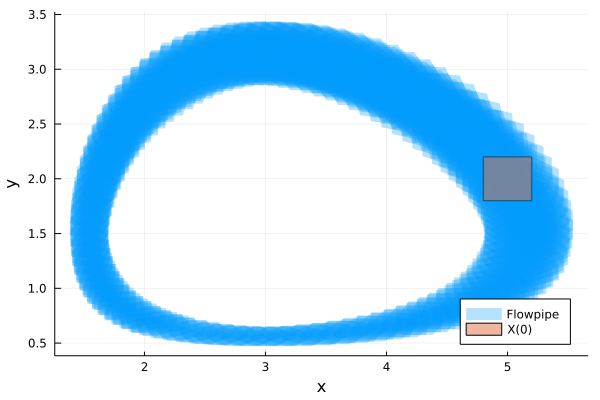

In [3]:
using Plots

plot(solz, vars=(1, 2), alpha=0.3,lw=0., xlab="x", ylab="y", label="Flowpipe", legend=:bottomright)
plot!(X0, label="X(0)")

# Adding parameter variation

In [4]:
@taylorize function f(du, u, p, t)
    du[1] = u[3] * u[1] - u[4] * (u[1] * u[2]) - u[7] * u[1]^2
    du[2] = -u[5] * u[2] + u[6] * (u[1] * u[2])

    #encode uncertain params
    du[3] = zero(u[1]) # p[1]
    du[4] = zero(u[1]) # p[2]
    du[5] = zero(u[1]) # p[3]
    du[6] = zero(u[1]) # p[4]
    du[7] = zero(u[1]) # p[5]
end

encode initial-value problem

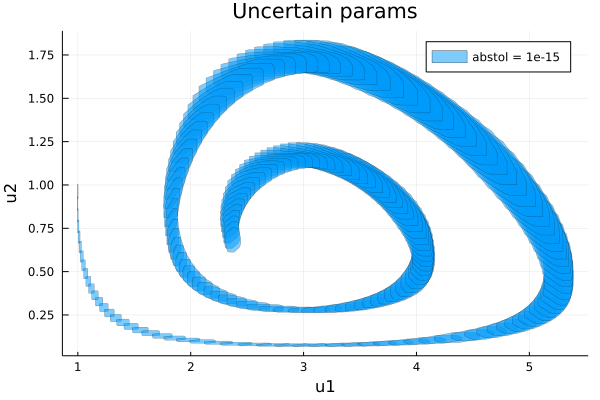

In [5]:
p_int = (0.99..1.01) × (0.99..1.01) × (2.99..3.01) × (0.99..1.01) × (0.099..0.101)
U0 = Singleton([1.0, 1.0]) × convert(Hyperrectangle, p_int)
prob = @ivp(u' = f(u), dim: 7, u(0) ∈ U0);

sol = solve(prob, tspan=(0.0, 10.0));
solz = overapproximate(sol, Zonotope);

plot(solz, vars=(1, 2), lw=0.3, title="Uncertain params", lab="abstol = 1e-15", xlab="u1", ylab="u2")

# Uncertain initial condition (u0)

Now we consider an initial box around u0

### ``\epsilon = 0.05``

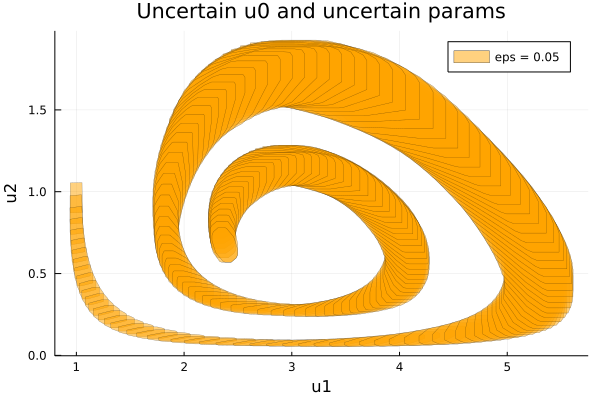

In [6]:
u0 = Singleton([1.0, 1.0])
□(ϵ) = BallInf(zeros(2), ϵ)
U0 = (u0 ⊕ □(0.05)) × convert(Hyperrectangle, p_int)

prob = @ivp(u' = f(u), dim: 7, u(0) ∈ U0)

sol = solve(prob, tspan=(0.0, 10.0), TMJets(abstol=1e-10))
solz = overapproximate(sol, Zonotope)
plot(solz, vars=(1, 2), color=:orange, lw=0.3,
     lab="eps = 0.05", title="Uncertain u0 and uncertain params",
     xlab="u1", ylab="u2")

### ``\epsilon = 0.01``

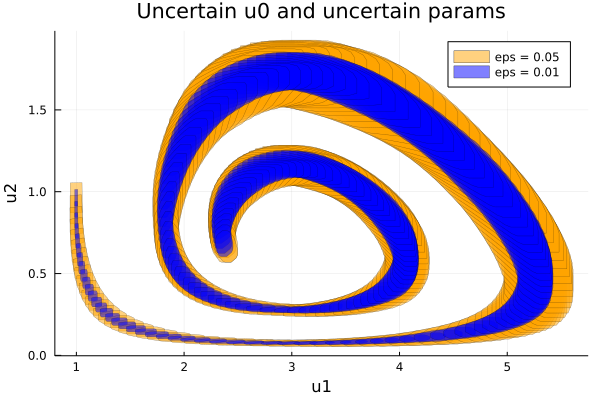

In [7]:
U0 = (u0 ⊕ □(0.01)) × convert(Hyperrectangle, p_int)
prob = @ivp(u' = f(u), dim: 7, u(0) ∈ U0)

sol = solve(prob, tspan=(0.0, 10.0), TMJets(abstol=1e-10))
solz = overapproximate(sol, Zonotope)
plot!(solz, vars=(1, 2), color=:blue, lw=0.3,
  lab="eps = 0.01", title="Uncertain u0 and uncertain params",
  xlab="u1", ylab="u2")